In [2]:
import numpy as np
import keras
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


# Iris dataset

### Dataset load and setting

In [3]:
# create object of class 'load_iris'
iris = load_iris()

In [4]:
# save features and targets from the 'iris'
features, targets = iris.data, iris.target


### Dataset Split into:
Train, test and validation

In [5]:
# Split: train_size=0.8 and test_size=0.2
# in a second split the test size will be split into two. 
# It will be 0.1 to test set  and 0.1 to validation set  
train_features, test_features, train_targets, test_targets = train_test_split(
        features, targets,
        train_size=0.8,
        test_size=0.2,
        random_state=23,
        stratify=targets
    )

In [6]:
 class_number = len(np.unique(targets))

In [7]:
# amount of classes to the problem
class_number

3

In [8]:
test_features.shape

(30, 4)

In [9]:
train_features.shape

(120, 4)

## Amount of half of the test's first split

In [10]:
half_test_samples = int((len(test_features))/2)

### Split of the test set into half

In [11]:
val_features = test_features[:half_test_samples]

In [12]:
val_features.shape

(15, 4)

In [13]:
val_targets = test_targets[:half_test_samples]

### Test set now is it's half size

In [14]:
test_features = test_features[half_test_samples:]

In [15]:
test_features.shape

(15, 4)

In [16]:
test_targets = test_targets[half_test_samples:]

In [17]:
test_targets

array([1, 2, 1, 1, 2, 0, 2, 2, 0, 0, 0, 0, 1, 1, 1])

In [18]:
test_targets_metrics = test_targets

## Model Creation

In [19]:
def create_MLP_model(classes_number):
    """
    Function to create a MLP model
    classes_number: Number of classes to be classified
    
    return model - model to be used in the training stage
    """
    input_dim = 4
    model = Sequential()
    model.add(Dense(64, input_dim=4, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    return model

## Encoding classes

In [20]:
train_targets = keras.utils.np_utils.to_categorical(train_targets, class_number)
test_targets = keras.utils.np_utils.to_categorical(test_targets, class_number)
val_targets = keras.utils.np_utils.to_categorical(val_targets, class_number)

### Model compilation

In [21]:
model = create_MLP_model(class_number)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
 model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 515
Trainable params: 515
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.compile(optimizer=SGD(lr=0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [101]:
#variables and constants to the model training
callbacks_list = []
path_to_save_model = "model/best_model.h5"



### Callbacks

In [102]:
#model checkpoint to save just the best model with the lowest loss
model_checkpoint = ModelCheckpoint(path_to_save_model,
                                   monitor='val_loss',
                                   verbose=2,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

callbacks_list.append(model_checkpoint)

In [103]:
early_stop_callback = EarlyStopping(monitor='val_loss',
                                    min_delta=0,  
                                    patience=10,
                                    verbose=2,
                                    mode='auto',
                                    baseline=None,
                                    restore_best_weights=False)

callbacks_list.append(early_stop_callback)

In [104]:
history = model.fit(train_features,
                    train_targets,
                    batch_size=32,
                    epochs=300,
                    verbose=2,
                    callbacks = callbacks_list,
                    validation_data=(val_features, val_targets))

Train on 120 samples, validate on 15 samples
Epoch 1/300
 - 1s - loss: 0.2006 - acc: 0.9417 - val_loss: 0.1411 - val_acc: 0.9333

Epoch 00001: val_loss improved from inf to 0.14109, saving model to model/best_model.h5
Epoch 2/300
 - 0s - loss: 0.2032 - acc: 0.9333 - val_loss: 0.1088 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.14109 to 0.10876, saving model to model/best_model.h5
Epoch 3/300
 - 0s - loss: 0.2202 - acc: 0.9000 - val_loss: 0.1258 - val_acc: 1.0000

Epoch 00003: val_loss did not improve from 0.10876
Epoch 4/300
 - 0s - loss: 0.1927 - acc: 0.9083 - val_loss: 0.1319 - val_acc: 0.9333

Epoch 00004: val_loss did not improve from 0.10876
Epoch 5/300
 - 0s - loss: 0.1737 - acc: 0.9250 - val_loss: 0.1504 - val_acc: 0.9333

Epoch 00005: val_loss did not improve from 0.10876
Epoch 6/300
 - 0s - loss: 0.1914 - acc: 0.9167 - val_loss: 0.1257 - val_acc: 1.0000

Epoch 00006: val_loss did not improve from 0.10876
Epoch 7/300
 - 0s - loss: 0.1988 - acc: 0.9333 - val_loss: 0.

### Test saved model

In [105]:
model = load_model(path_to_save_model)

In [106]:
_, accuracy = model.evaluate(test_features, test_targets)

15/15 [==============================] - 0s 12ms/step


In [107]:
predictions = model.predict(test_features)

In [108]:
print('Accuracy: %.2f' % (accuracy*100))


Accuracy: 93.33


### Confusion Matrix

In [109]:
confusion_matrix(test_targets.argmax(axis=1), predictions.argmax(axis=1))

array([[5, 0, 0],
       [0, 5, 1],
       [0, 0, 4]])

### Other metrics of the model
Precision, recall and f1-score

In [110]:
print(classification_report(test_targets_metrics,predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.83      0.91         6
           2       0.80      1.00      0.89         4

   micro avg       0.93      0.93      0.93        15
   macro avg       0.93      0.94      0.93        15
weighted avg       0.95      0.93      0.93        15



### Accuracy and Loss plot

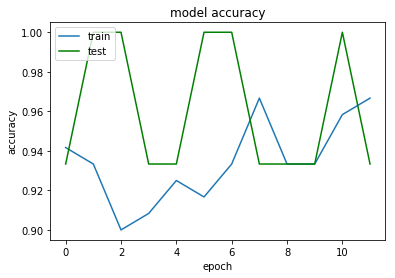

In [111]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'], 'g')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accurary_1.png')

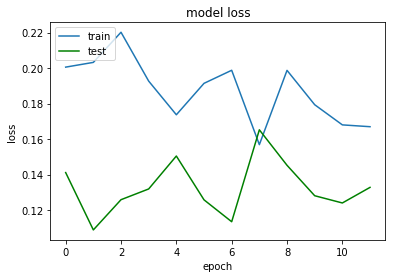

In [112]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_loss_1.png')

## Segunda abordagem: mais camadas escondidas no modelo

In [57]:
def create_MLP_model(classes_number):
    """
    Function to create a MLP model
    classes_number: Number of classes to be classified
    
    return model - model to be used in the training stage
    """
    input_dim = 4
    model = Sequential()
    model.add(Dense(32, input_dim=4, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(32, input_dim=input_dim, activation='sigmoid'))
    model.add(Dropout(0.5))
#     model.add(Dense(64, input_dim=input_dim, activation='sigmoid'))
    model.add(Dense(3, activation='softmax'))

    return model

In [58]:
model2 = create_MLP_model(class_number)

In [59]:
 model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                160       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 99        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________


In [114]:
path_to_save_model2 = "model/best_model2.h5"

In [115]:
model2.compile(optimizer=SGD(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [119]:
history2 = model2.fit(train_features,
                    train_targets,
                    batch_size=32,
                    epochs=600,
                    verbose=2,
                    callbacks=[early_stop_callback],
                    validation_data=(val_features, val_targets))

Train on 120 samples, validate on 15 samples
Epoch 1/600
 - 0s - loss: 0.6208 - acc: 0.7000 - val_loss: 0.4432 - val_acc: 1.0000
Epoch 2/600
 - 0s - loss: 0.6283 - acc: 0.6750 - val_loss: 0.4435 - val_acc: 1.0000
Epoch 3/600
 - 0s - loss: 0.5936 - acc: 0.7083 - val_loss: 0.4426 - val_acc: 1.0000
Epoch 4/600
 - 0s - loss: 0.6186 - acc: 0.6667 - val_loss: 0.4427 - val_acc: 1.0000
Epoch 5/600
 - 0s - loss: 0.5540 - acc: 0.7833 - val_loss: 0.4419 - val_acc: 1.0000
Epoch 6/600
 - 0s - loss: 0.5671 - acc: 0.6667 - val_loss: 0.4423 - val_acc: 1.0000
Epoch 7/600
 - 0s - loss: 0.5823 - acc: 0.6917 - val_loss: 0.4411 - val_acc: 1.0000
Epoch 8/600
 - 0s - loss: 0.5493 - acc: 0.7250 - val_loss: 0.4410 - val_acc: 1.0000
Epoch 9/600
 - 0s - loss: 0.5755 - acc: 0.7500 - val_loss: 0.4402 - val_acc: 1.0000
Epoch 10/600
 - 0s - loss: 0.5581 - acc: 0.7333 - val_loss: 0.4404 - val_acc: 1.0000
Epoch 11/600
 - 0s - loss: 0.5239 - acc: 0.7750 - val_loss: 0.4404 - val_acc: 1.0000
Epoch 12/600
 - 0s - loss: 0.

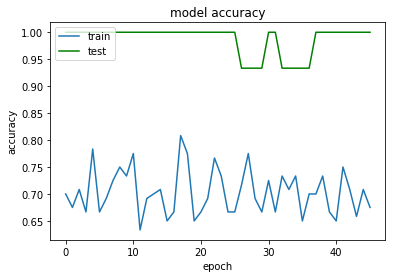

In [120]:
plt.figure()
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'], 'g')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accurary_2_approach.png')

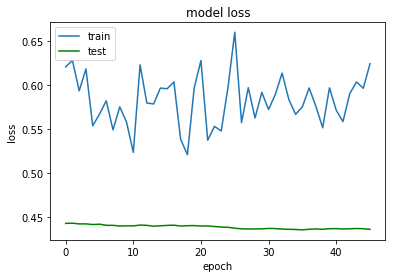

In [121]:
plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'], 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_loss_2_approach.png')

In [123]:
_, accuracy2 = model2.evaluate(test_features, test_targets)

predictions2 = model2.predict(test_features)

print('Accuracy: %.2f' % (accuracy2*100))


### Confusion Matrix

print(confusion_matrix(test_targets.argmax(axis=1), predictions2.argmax(axis=1)))

### Other metrics of the model
##Precision, recall and f1-score

print(classification_report(test_targets_metrics,predictions2.argmax(axis=1)))

15/15 [==============================] - 0s 103us/step
Accuracy: 86.67
[[5 0 0]
 [0 4 2]
 [0 0 4]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.67      0.80         6
           2       0.67      1.00      0.80         4

   micro avg       0.87      0.87      0.87        15
   macro avg       0.89      0.89      0.87        15
weighted avg       0.91      0.87      0.87        15

